# **Sessa Empirical Estimator**  
**Assignment 2 For Clustering**  
- **Honoridez, Kyn R.**  
- **Montebon, Al Winmon**  

## **Introduction**  
This assignment focuses on implementing the **Sessa Empirical Estimator (SEE)**, which utilizes **K-Means clustering** to analyze datasets. Additionally, we compare K-Means with another clustering algorithm, **DBSCAN**, to assess performance differences.  

The main goal is to convert an **R implementation** into **Python**, apply it to simulated or real-world data, and generate insights. Finally, we compare clustering results and justify why **DBSCAN is often preferred over K-Means**.



## **Importing Required Libraries and Loading and Preprocessing Data**
We import the necessary Python libraries for data processing, clustering, and visualization. This function loads the dataset and preprocesses the DATE column.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from IPython.display import display, Markdown


def load_and_preprocess_data(filename):
    """Load dataset and preprocess DATE column."""
    med_events = pd.read_csv(filename)
    med_events['DATE'] = pd.to_datetime(med_events['DATE'], format='%m/%d/%Y')
    med_events['DATE'] = (med_events['DATE'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
    return med_events

## **Scaling and Dimensionality Reduction and applying K-means Clustering**
This function scales the DATE, DURATION, and PERDAY columns and applies PCA to reduce dimensions and applies K-Means clustering to the transformed data..

In [2]:

def scale_and_reduce_dimensionality(data):
    """Scales DATE, DURATION, PERDAY and applies PCA."""
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[['DATE', 'DURATION', 'PERDAY']])
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)
    return data_pca

def apply_kmeans(data_pca, num_clusters=6):
    """Applies K-Means clustering."""
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    return kmeans.fit_predict(data_pca)

## **Tuning DBSCAN Parameters**
This function finds the best epsilon (eps) for DBSCAN using a grid search.

In [3]:
def tune_dbscan(data_pca):
    """Finds the best eps for DBSCAN using grid search."""
    best_eps, best_score, best_metric = None, -1, None
    for metric in ['euclidean', 'manhattan']:
        for eps in np.arange(1.0, 2.5, 0.1):
            dbscan = DBSCAN(eps=eps, min_samples=8, metric=metric)
            clusters = dbscan.fit_predict(data_pca)
            num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
            if num_clusters > 1:
                score = silhouette_score(data_pca, clusters)
                if score > best_score:
                    best_score, best_eps, best_metric = score, eps, metric
    return best_eps, best_metric



## **Applying DBSCAN Clustering**
This function applies DBSCAN clustering using the best hyperparameters.

In [4]:
def apply_dbscan(data_pca, eps, metric):
    """Applies DBSCAN with the best hyperparameters."""
    dbscan = DBSCAN(eps=eps, min_samples=8, metric=metric)
    return dbscan.fit_predict(data_pca)


## **Evaluating Clustering Performance**
This function computes silhouette and Davies-Bouldin scores for K-Means and DBSCAN.

In [5]:
def evaluate_clustering(data_pca, kmeans_labels, dbscan_labels):
    """Computes silhouette and Davies-Bouldin scores."""
    kmeans_silhouette = silhouette_score(data_pca, kmeans_labels)
    kmeans_db_index = davies_bouldin_score(data_pca, kmeans_labels)
    dbscan_clusters = set(dbscan_labels)
    dbscan_clusters.discard(-1)
    num_clusters_dbscan = len(dbscan_clusters)
    
    if num_clusters_dbscan > 1:
        dbscan_silhouette = silhouette_score(data_pca, dbscan_labels)
        dbscan_db_index = davies_bouldin_score(data_pca, dbscan_labels)
    else:
        dbscan_silhouette = 'N/A'
        dbscan_db_index = 'N/A'
    
    return {
        "kmeans_silhouette": kmeans_silhouette,
        "kmeans_db_index": kmeans_db_index,
        "dbscan_silhouette": dbscan_silhouette,
        "dbscan_db_index": dbscan_db_index
    }

## **Visualizing Clusters**
This function plots the DBSCAN clustering results.

In [6]:
def visualize_clusters(data_pca, labels, title, method="DBSCAN", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))  # Create a new figure if no axis is provided
    
    # Choose colormap based on clustering method
    cmap = "viridis" if method == "DBSCAN" else "coolwarm"

    scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap=cmap, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    
    # Add a color bar only if plotting standalone (not in subplots)
    if fig := plt.gcf():
        fig.colorbar(scatter, ax=ax)

    return ax  # Return the axis in case it's needed


## **Loading Dataset and Splitting by Category**
We load the dataset and separate data by medication category (medA and medB).

In [7]:
# Load and preprocess dataset
med_events = load_and_preprocess_data("med.events.csv")

# Separate data by category
medA = med_events[med_events['CATEGORY'] == 'medA'].copy()
medB = med_events[med_events['CATEGORY'] == 'medB'].copy()

## **Running the Clustering Workflow**
This function executes the full clustering workflow for a given dataset.

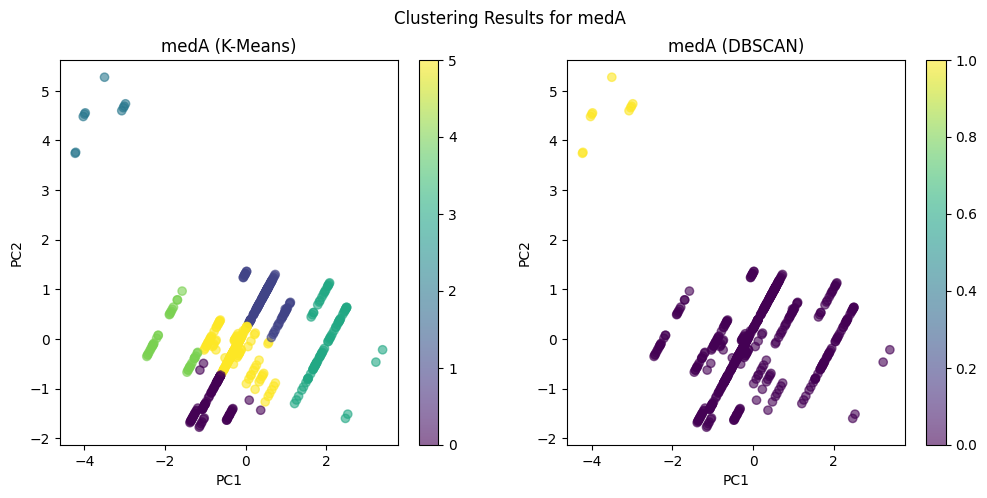

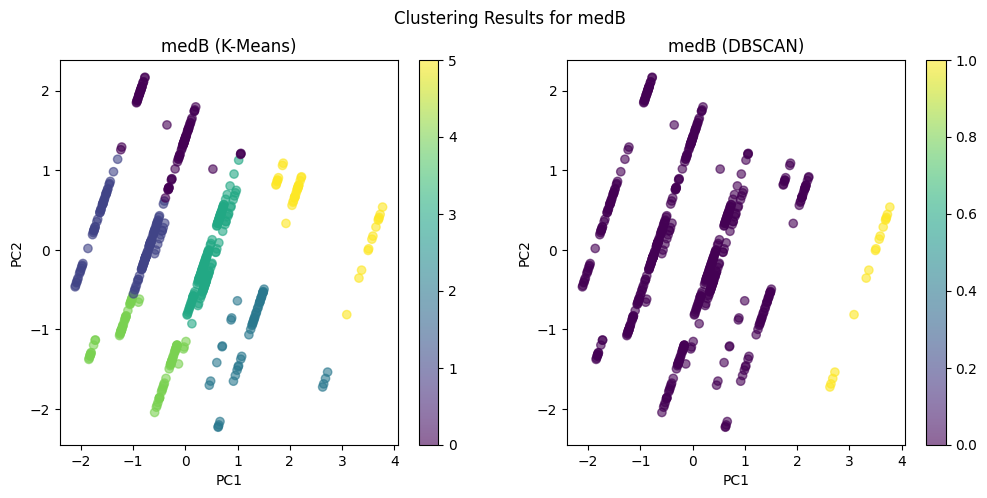

In [8]:
def perform_clustering_workflow_vis(data, category):
    # Perform clustering
    data_pca = scale_and_reduce_dimensionality(data)
    kmeans_labels = apply_kmeans(data_pca)
    best_eps, best_metric = tune_dbscan(data_pca)
    dbscan_labels = apply_dbscan(data_pca, best_eps, best_metric)
    
    # Create side-by-side visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # K-Means visualization
    visualize_clusters(data_pca, kmeans_labels, category + " (K-Means)", ax=axes[0])

    # DBSCAN visualization
    visualize_clusters(data_pca, dbscan_labels, category + " (DBSCAN)", ax=axes[1])

    plt.suptitle(f"Clustering Results for {category}")
    plt.show()

# **Run this in one Jupyter cell**
perform_clustering_workflow_vis(medA, 'medA')
perform_clustering_workflow_vis(medB, 'medB')


In [9]:
def perform_clustering_workflow_results(data, category):
    # Perform clustering
    data_pca = scale_and_reduce_dimensionality(data)
    kmeans_labels = apply_kmeans(data_pca)
    best_eps, best_metric = tune_dbscan(data_pca)
    dbscan_labels = apply_dbscan(data_pca, best_eps, best_metric)
    results = evaluate_clustering(data_pca, kmeans_labels, dbscan_labels)
    
    # Create Markdown-formatted table output
    markdown_output = f"""
### **Final Cluster Comparison: {category}**
| Metric                   | K-Means | DBSCAN  |
|--------------------------|---------|---------|
| **Silhouette Score**     | `{results['kmeans_silhouette']:.2f}` | `{results['dbscan_silhouette']:.2f}` |
| **Davies-Bouldin Index** | `{results['kmeans_db_index']:.2f}` | `{results['dbscan_db_index']:.2f}` |
"""

    # Display as Markdown table
    display(Markdown(markdown_output))

# **Run this in a separate Jupyter cell**
perform_clustering_workflow_results(medA, 'medA')
perform_clustering_workflow_results(medB, 'medB')



### **Final Cluster Comparison: medA**
| Metric                   | K-Means | DBSCAN  |
|--------------------------|---------|---------|
| **Silhouette Score**     | `0.51` | `0.73` |
| **Davies-Bouldin Index** | `0.60` | `0.30` |



### **Final Cluster Comparison: medB**
| Metric                   | K-Means | DBSCAN  |
|--------------------------|---------|---------|
| **Silhouette Score**     | `0.48` | `0.50` |
| **Davies-Bouldin Index** | `0.81` | `0.59` |


The results show that **DBSCAN performs better than K-Means, especially for medA**, with a higher Silhouette Score and a lower Davies-Bouldin Index . This suggests DBSCAN forms clearer, well-separated clusters, while K-Means struggles with non-uniform data. For medB, the difference is smaller, but DBSCAN still has a slight edge. Since SEE relies on K-Means, its performance may be affected by these limitations, and **alternative clustering methods like DBSCAN could improve results in complex datasets**.



# **Conclusion**  

Since the Sessa Empirical Estimator (SEE) is based on K-Means, it may inherit its limitations—especially its sensitivity to outliers and difficulty handling non-spherical clusters. Substituting DBSCAN or another density-based algorithm in SEE could improve its effectiveness, particularly for datasets with complex or irregular cluster structures, making it a more robust approach for medical event analysis.